In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
filename = "cg-X_16396x224x224x3.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, X)

Saving file cg-X_16396x224x224x3.npy ...


In [7]:
filename = "cg-y_numclass.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, y)

Saving file cg-y_numclass.npy ...


In [8]:
filename = "cg-Y_onehotencode.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, Y)

Saving file cg-Y_onehotencode.npy ...


In [10]:
# Creating base model (VGG19 convolutional layers)
img_shape = (224, 224, 3)                                                                                                                                               
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])       

In [13]:
vgg19weights = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
model.load_weights(vgg19weights, by_name=True)

In [14]:
filename = 'cg-vgg19features.npy'
if os.path.exists(filename):
    print("Loading VGG19 extracted features from %s ..." %(filename))
    vggfeatures = np.load(filename)
else:
    print("Extracting features from VGG19 convolutional layers ...")
    vggfeatures = model.predict(X)
    print("Saving VGG19 extracted features into %s ..." %(filename))
    np.save(filename, vggfeatures)

Loading VGG19 extracted features from cg-vgg19features.npy ...


In [15]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [16]:
# Training top_model and saving min training loss weights
num_epochs=200
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-vgg19-2layers-160neurons-relu-0.4dropout-Adam-200epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vggfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = vggfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 14755 samples, validate on 1641 samples
Epoch 1/200
14755/14755 [==============================] - 4s - loss: 5.2736 - acc: 0.4783 - val_loss: 5.1544 - val_acc: 0.6039
Epoch 2/200
14755/14755 [==============================] - 3s - loss: 5.1748 - acc: 0.6099 - val_loss: 1.6988 - val_acc: 0.8410
Epoch 3/200
14755/14755 [==============================] - 3s - loss: 2.2549 - acc: 0.7979 - val_loss: 2.8597 - val_acc: 0.7654
Epoch 4/200
14755/14755 [==============================] - 3s - loss: 2.6375 - acc: 0.7799 - val_loss: 2.2345 - val_acc: 0.8172
Epoch 5/200
14755/14755 [==============================] - 3s - loss: 2.2321 - acc: 0.8124 - val_loss: 1.5263 - val_acc: 0.8611
Epoch 6/200
14755/14755 [==============================] - 3s - loss: 1.7891 - acc: 0.8469 - val_loss: 1.7168 - val_acc: 0.8580
Epoch 7/200
14755/14755 [==============================] - 3s - loss: 1.8812 - acc: 0.8481 - val_loss: 1.5923 - val_acc: 0.8659
Epoch 8/200
14755/14755 [==============================

14755/14755 [==============================] - 3s - loss: 0.0636 - acc: 0.9686 - val_loss: 0.5813 - val_acc: 0.9214
Epoch 65/200
14755/14755 [==============================] - 3s - loss: 0.0644 - acc: 0.9683 - val_loss: 0.5853 - val_acc: 0.9238
Epoch 66/200
14755/14755 [==============================] - 3s - loss: 0.0641 - acc: 0.9667 - val_loss: 0.5908 - val_acc: 0.9232
Epoch 67/200
14755/14755 [==============================] - 3s - loss: 0.0626 - acc: 0.9686 - val_loss: 0.5980 - val_acc: 0.9214
Epoch 68/200
14755/14755 [==============================] - 3s - loss: 0.0607 - acc: 0.9686 - val_loss: 0.6044 - val_acc: 0.9220
Epoch 69/200
14755/14755 [==============================] - 3s - loss: 0.0631 - acc: 0.9686 - val_loss: 0.6066 - val_acc: 0.9238
Epoch 70/200
14755/14755 [==============================] - 3s - loss: 0.0618 - acc: 0.9688 - val_loss: 0.6077 - val_acc: 0.9232
Epoch 71/200
14755/14755 [==============================] - 3s - loss: 0.0598 - acc: 0.9709 - val_loss: 0.6091

14755/14755 [==============================] - 3s - loss: 0.0368 - acc: 0.9795 - val_loss: 0.6710 - val_acc: 0.9281
Epoch 128/200
14755/14755 [==============================] - 3s - loss: 0.0357 - acc: 0.9811 - val_loss: 0.6748 - val_acc: 0.9293
Epoch 129/200
14755/14755 [==============================] - 3s - loss: 0.0344 - acc: 0.9801 - val_loss: 0.6779 - val_acc: 0.9293
Epoch 130/200
14755/14755 [==============================] - 3s - loss: 0.0365 - acc: 0.9792 - val_loss: 0.6798 - val_acc: 0.9299
Epoch 131/200
14755/14755 [==============================] - 3s - loss: 0.0348 - acc: 0.9814 - val_loss: 0.6790 - val_acc: 0.9299
Epoch 132/200
14755/14755 [==============================] - 3s - loss: 0.0347 - acc: 0.9818 - val_loss: 0.6793 - val_acc: 0.9305
Epoch 133/200
14755/14755 [==============================] - 3s - loss: 0.0343 - acc: 0.9816 - val_loss: 0.6786 - val_acc: 0.9317
Epoch 134/200
14755/14755 [==============================] - 3s - loss: 0.0339 - acc: 0.9817 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0298 - acc: 0.9837 - val_loss: 0.6974 - val_acc: 0.9305
Epoch 191/200
14755/14755 [==============================] - 3s - loss: 0.0308 - acc: 0.9826 - val_loss: 0.6950 - val_acc: 0.9305
Epoch 192/200
14755/14755 [==============================] - 3s - loss: 0.0297 - acc: 0.9845 - val_loss: 0.6952 - val_acc: 0.9305
Epoch 193/200
14755/14755 [==============================] - 3s - loss: 0.0285 - acc: 0.9841 - val_loss: 0.6953 - val_acc: 0.9311
Epoch 194/200
14755/14755 [==============================] - 3s - loss: 0.0302 - acc: 0.9834 - val_loss: 0.6939 - val_acc: 0.9311
Epoch 195/200
14755/14755 [==============================] - 3s - loss: 0.0301 - acc: 0.9839 - val_loss: 0.6868 - val_acc: 0.9311
Epoch 196/200
14755/14755 [==============================] - 3s - loss: 0.0287 - acc: 0.9839 - val_loss: 0.6809 - val_acc: 0.9287
Epoch 197/200
14755/14755 [==============================] - 3s - loss: 0.0298 - acc: 0.9835 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0776 - acc: 0.9557 - val_loss: 0.3822 - val_acc: 0.9324
Epoch 54/200
14755/14755 [==============================] - 3s - loss: 0.0748 - acc: 0.9554 - val_loss: 0.3876 - val_acc: 0.9330
Epoch 55/200
14755/14755 [==============================] - 3s - loss: 0.0702 - acc: 0.9577 - val_loss: 0.3945 - val_acc: 0.9342
Epoch 56/200
14755/14755 [==============================] - 3s - loss: 0.0670 - acc: 0.9620 - val_loss: 0.4003 - val_acc: 0.9354
Epoch 57/200
14755/14755 [==============================] - 3s - loss: 0.0706 - acc: 0.9574 - val_loss: 0.4046 - val_acc: 0.9366
Epoch 58/200
14755/14755 [==============================] - 3s - loss: 0.0703 - acc: 0.9564 - val_loss: 0.4041 - val_acc: 0.9366
Epoch 59/200
14755/14755 [==============================] - 3s - loss: 0.0656 - acc: 0.9591 - val_loss: 0.4048 - val_acc: 0.9366
Epoch 60/200
14755/14755 [==============================] - 3s - loss: 0.0649 - acc: 0.9602 - val_loss: 0.4050

14755/14755 [==============================] - 3s - loss: 0.0422 - acc: 0.9755 - val_loss: 0.4395 - val_acc: 0.9378
Epoch 117/200
14755/14755 [==============================] - 3s - loss: 0.0405 - acc: 0.9772 - val_loss: 0.4425 - val_acc: 0.9385
Epoch 118/200
14755/14755 [==============================] - 3s - loss: 0.0397 - acc: 0.9757 - val_loss: 0.4457 - val_acc: 0.9385
Epoch 119/200
14755/14755 [==============================] - 3s - loss: 0.0417 - acc: 0.9737 - val_loss: 0.4452 - val_acc: 0.9385
Epoch 120/200
14755/14755 [==============================] - 3s - loss: 0.0417 - acc: 0.9758 - val_loss: 0.4453 - val_acc: 0.9385
Epoch 121/200
14755/14755 [==============================] - 3s - loss: 0.0406 - acc: 0.9753 - val_loss: 0.4444 - val_acc: 0.9372
Epoch 122/200
14755/14755 [==============================] - 3s - loss: 0.0406 - acc: 0.9755 - val_loss: 0.4407 - val_acc: 0.9391
Epoch 123/200
14755/14755 [==============================] - 3s - loss: 0.0387 - acc: 0.9784 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0335 - acc: 0.9795 - val_loss: 0.4418 - val_acc: 0.9403
Epoch 180/200
14755/14755 [==============================] - 3s - loss: 0.0342 - acc: 0.9782 - val_loss: 0.4436 - val_acc: 0.9403
Epoch 181/200
14755/14755 [==============================] - 3s - loss: 0.0327 - acc: 0.9800 - val_loss: 0.4439 - val_acc: 0.9403
Epoch 182/200
14755/14755 [==============================] - 3s - loss: 0.0330 - acc: 0.9795 - val_loss: 0.4448 - val_acc: 0.9409
Epoch 183/200
14755/14755 [==============================] - 3s - loss: 0.0334 - acc: 0.9793 - val_loss: 0.4476 - val_acc: 0.9409
Epoch 184/200
14755/14755 [==============================] - 3s - loss: 0.0329 - acc: 0.9793 - val_loss: 0.4505 - val_acc: 0.9415
Epoch 185/200
14755/14755 [==============================] - 3s - loss: 0.0343 - acc: 0.9786 - val_loss: 0.4519 - val_acc: 0.9409
Epoch 186/200
14755/14755 [==============================] - 3s - loss: 0.0331 - acc: 0.9805 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.0964 - acc: 0.9509 - val_loss: 0.4155 - val_acc: 0.9177
Epoch 42/200
14756/14756 [==============================] - 3s - loss: 0.0920 - acc: 0.9536 - val_loss: 0.4166 - val_acc: 0.9183
Epoch 43/200
14756/14756 [==============================] - 3s - loss: 0.0898 - acc: 0.9543 - val_loss: 0.4187 - val_acc: 0.9171
Epoch 44/200
14756/14756 [==============================] - 3s - loss: 0.0875 - acc: 0.9558 - val_loss: 0.4212 - val_acc: 0.9171
Epoch 45/200
14756/14756 [==============================] - 3s - loss: 0.0849 - acc: 0.9575 - val_loss: 0.4229 - val_acc: 0.9183
Epoch 46/200
14756/14756 [==============================] - 3s - loss: 0.0858 - acc: 0.9557 - val_loss: 0.4276 - val_acc: 0.9189
Epoch 47/200
14756/14756 [==============================] - 3s - loss: 0.0827 - acc: 0.9568 - val_loss: 0.4328 - val_acc: 0.9201
Epoch 48/200
14756/14756 [==============================] - 3s - loss: 0.0796 - acc: 0.9581 - val_loss: 0.4391

14756/14756 [==============================] - 3s - loss: 0.0429 - acc: 0.9753 - val_loss: 0.5610 - val_acc: 0.9220
Epoch 105/200
14756/14756 [==============================] - 3s - loss: 0.0411 - acc: 0.9747 - val_loss: 0.5628 - val_acc: 0.9238
Epoch 106/200
14756/14756 [==============================] - 3s - loss: 0.0416 - acc: 0.9755 - val_loss: 0.5649 - val_acc: 0.9244
Epoch 107/200
14756/14756 [==============================] - 3s - loss: 0.0396 - acc: 0.9766 - val_loss: 0.5673 - val_acc: 0.9250
Epoch 108/200
14756/14756 [==============================] - 3s - loss: 0.0397 - acc: 0.9763 - val_loss: 0.5707 - val_acc: 0.9262
Epoch 109/200
14756/14756 [==============================] - 3s - loss: 0.0409 - acc: 0.9749 - val_loss: 0.5729 - val_acc: 0.9262
Epoch 110/200
14756/14756 [==============================] - 3s - loss: 0.0434 - acc: 0.9756 - val_loss: 0.5749 - val_acc: 0.9262
Epoch 111/200
14756/14756 [==============================] - 3s - loss: 0.0407 - acc: 0.9778 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.0304 - acc: 0.9812 - val_loss: 0.5834 - val_acc: 0.9299
Epoch 168/200
14756/14756 [==============================] - 3s - loss: 0.0298 - acc: 0.9816 - val_loss: 0.5855 - val_acc: 0.9299
Epoch 169/200
14756/14756 [==============================] - 3s - loss: 0.0298 - acc: 0.9817 - val_loss: 0.5859 - val_acc: 0.9299
Epoch 170/200
14756/14756 [==============================] - 3s - loss: 0.0302 - acc: 0.9822 - val_loss: 0.5862 - val_acc: 0.9299
Epoch 171/200
14756/14756 [==============================] - 3s - loss: 0.0291 - acc: 0.9829 - val_loss: 0.5883 - val_acc: 0.9299
Epoch 172/200
14756/14756 [==============================] - 3s - loss: 0.0305 - acc: 0.9820 - val_loss: 0.5892 - val_acc: 0.9299
Epoch 173/200
14756/14756 [==============================] - 3s - loss: 0.0298 - acc: 0.9809 - val_loss: 0.5876 - val_acc: 0.9287
Epoch 174/200
14756/14756 [==============================] - 3s - loss: 0.0284 - acc: 0.9816 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.6013 - acc: 0.9287 - val_loss: 0.7233 - val_acc: 0.9171
Epoch 30/200
14756/14756 [==============================] - 3s - loss: 0.5587 - acc: 0.9284 - val_loss: 0.6705 - val_acc: 0.9177
Epoch 31/200
14756/14756 [==============================] - 3s - loss: 0.5101 - acc: 0.9313 - val_loss: 0.6224 - val_acc: 0.9171
Epoch 32/200
14756/14756 [==============================] - 3s - loss: 0.4777 - acc: 0.9298 - val_loss: 0.5753 - val_acc: 0.9195
Epoch 33/200
14756/14756 [==============================] - 3s - loss: 0.4406 - acc: 0.9286 - val_loss: 0.5338 - val_acc: 0.9189
Epoch 34/200
14756/14756 [==============================] - 3s - loss: 0.3962 - acc: 0.9320 - val_loss: 0.5068 - val_acc: 0.9140
Epoch 35/200
14756/14756 [==============================] - 3s - loss: 0.3696 - acc: 0.9313 - val_loss: 0.4922 - val_acc: 0.9128
Epoch 36/200
14756/14756 [==============================] - 3s - loss: 0.3523 - acc: 0.9276 - val_loss: 0.4775

14756/14756 [==============================] - 3s - loss: 0.0527 - acc: 0.9779 - val_loss: 0.5441 - val_acc: 0.9287
Epoch 93/200
14756/14756 [==============================] - 3s - loss: 0.0495 - acc: 0.9791 - val_loss: 0.5435 - val_acc: 0.9287
Epoch 94/200
14756/14756 [==============================] - 3s - loss: 0.0508 - acc: 0.9787 - val_loss: 0.5439 - val_acc: 0.9280
Epoch 95/200
14756/14756 [==============================] - 3s - loss: 0.0503 - acc: 0.9782 - val_loss: 0.5431 - val_acc: 0.9287
Epoch 96/200
14756/14756 [==============================] - 3s - loss: 0.0459 - acc: 0.9800 - val_loss: 0.5443 - val_acc: 0.9287
Epoch 97/200
14756/14756 [==============================] - 3s - loss: 0.0502 - acc: 0.9778 - val_loss: 0.5460 - val_acc: 0.9293
Epoch 98/200
14756/14756 [==============================] - 3s - loss: 0.0469 - acc: 0.9793 - val_loss: 0.5486 - val_acc: 0.9311
Epoch 99/200
14756/14756 [==============================] - 3s - loss: 0.0484 - acc: 0.9795 - val_loss: 0.5505

14756/14756 [==============================] - 3s - loss: 0.0356 - acc: 0.9849 - val_loss: 0.6194 - val_acc: 0.9280
Epoch 156/200
14756/14756 [==============================] - 3s - loss: 0.0348 - acc: 0.9851 - val_loss: 0.6180 - val_acc: 0.9274
Epoch 157/200
14756/14756 [==============================] - 3s - loss: 0.0333 - acc: 0.9851 - val_loss: 0.6169 - val_acc: 0.9274
Epoch 158/200
14756/14756 [==============================] - 3s - loss: 0.0352 - acc: 0.9852 - val_loss: 0.6160 - val_acc: 0.9274
Epoch 159/200
14756/14756 [==============================] - 3s - loss: 0.0340 - acc: 0.9845 - val_loss: 0.6159 - val_acc: 0.9274
Epoch 160/200
14756/14756 [==============================] - 3s - loss: 0.0336 - acc: 0.9848 - val_loss: 0.6169 - val_acc: 0.9274
Epoch 161/200
14756/14756 [==============================] - 3s - loss: 0.0330 - acc: 0.9860 - val_loss: 0.6184 - val_acc: 0.9274
Epoch 162/200
14756/14756 [==============================] - 3s - loss: 0.0354 - acc: 0.9864 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3156 - acc: 0.8826 - val_loss: 0.3044 - val_acc: 0.8926
Epoch 18/200
14757/14757 [==============================] - 3s - loss: 0.2909 - acc: 0.8790 - val_loss: 0.2959 - val_acc: 0.8902
Epoch 19/200
14757/14757 [==============================] - 3s - loss: 0.2713 - acc: 0.8832 - val_loss: 0.2916 - val_acc: 0.8920
Epoch 20/200
14757/14757 [==============================] - 3s - loss: 0.2678 - acc: 0.8811 - val_loss: 0.2874 - val_acc: 0.8987
Epoch 21/200
14757/14757 [==============================] - 3s - loss: 0.2603 - acc: 0.8784 - val_loss: 0.2853 - val_acc: 0.9018
Epoch 22/200
14757/14757 [==============================] - 3s - loss: 0.2433 - acc: 0.8859 - val_loss: 0.2872 - val_acc: 0.9030
Epoch 23/200
14757/14757 [==============================] - 3s - loss: 0.2184 - acc: 0.8925 - val_loss: 0.2923 - val_acc: 0.9036
Epoch 24/200
14757/14757 [==============================] - 3s - loss: 0.2243 - acc: 0.8928 - val_loss: 0.2994

14757/14757 [==============================] - 3s - loss: 0.0450 - acc: 0.9754 - val_loss: 0.5157 - val_acc: 0.9341
Epoch 81/200
14757/14757 [==============================] - 3s - loss: 0.0488 - acc: 0.9741 - val_loss: 0.5181 - val_acc: 0.9341
Epoch 82/200
14757/14757 [==============================] - 3s - loss: 0.0474 - acc: 0.9757 - val_loss: 0.5228 - val_acc: 0.9347
Epoch 83/200
14757/14757 [==============================] - 3s - loss: 0.0457 - acc: 0.9765 - val_loss: 0.5289 - val_acc: 0.9347
Epoch 84/200
14757/14757 [==============================] - 3s - loss: 0.0459 - acc: 0.9751 - val_loss: 0.5321 - val_acc: 0.9341
Epoch 85/200
14757/14757 [==============================] - 3s - loss: 0.0431 - acc: 0.9766 - val_loss: 0.5362 - val_acc: 0.9329
Epoch 86/200
14757/14757 [==============================] - 3s - loss: 0.0420 - acc: 0.9764 - val_loss: 0.5405 - val_acc: 0.9329
Epoch 87/200
14757/14757 [==============================] - 3s - loss: 0.0422 - acc: 0.9774 - val_loss: 0.5436

14757/14757 [==============================] - 3s - loss: 0.0321 - acc: 0.9827 - val_loss: 0.5535 - val_acc: 0.9317
Epoch 144/200
14757/14757 [==============================] - 3s - loss: 0.0298 - acc: 0.9833 - val_loss: 0.5530 - val_acc: 0.9317
Epoch 145/200
14757/14757 [==============================] - 3s - loss: 0.0321 - acc: 0.9824 - val_loss: 0.5524 - val_acc: 0.9317
Epoch 146/200
14757/14757 [==============================] - 3s - loss: 0.0304 - acc: 0.9828 - val_loss: 0.5526 - val_acc: 0.9317
Epoch 147/200
14757/14757 [==============================] - 3s - loss: 0.0301 - acc: 0.9823 - val_loss: 0.5522 - val_acc: 0.9323
Epoch 148/200
14757/14757 [==============================] - 3s - loss: 0.0308 - acc: 0.9825 - val_loss: 0.5500 - val_acc: 0.9335
Epoch 149/200
14757/14757 [==============================] - 3s - loss: 0.0296 - acc: 0.9832 - val_loss: 0.5471 - val_acc: 0.9341
Epoch 150/200
14757/14757 [==============================] - 3s - loss: 0.0304 - acc: 0.9825 - val_loss:

14757/14757 [==============================] - 3s - loss: 6.8285 - acc: 0.5601 - val_loss: 5.9372 - val_acc: 0.6217
Epoch 6/200
14757/14757 [==============================] - 3s - loss: 6.1466 - acc: 0.6031 - val_loss: 5.2808 - val_acc: 0.6626
Epoch 7/200
14757/14757 [==============================] - 3s - loss: 5.3177 - acc: 0.6551 - val_loss: 4.3689 - val_acc: 0.7132
Epoch 8/200
14757/14757 [==============================] - 3s - loss: 4.6146 - acc: 0.6966 - val_loss: 3.4212 - val_acc: 0.7633
Epoch 9/200
14757/14757 [==============================] - 3s - loss: 4.2150 - acc: 0.7205 - val_loss: 3.8557 - val_acc: 0.7425
Epoch 10/200
14757/14757 [==============================] - 3s - loss: 4.1176 - acc: 0.7285 - val_loss: 3.7653 - val_acc: 0.7547
Epoch 11/200
14757/14757 [==============================] - 3s - loss: 3.9759 - acc: 0.7396 - val_loss: 3.1981 - val_acc: 0.7907
Epoch 12/200
14757/14757 [==============================] - 3s - loss: 3.4161 - acc: 0.7755 - val_loss: 2.7044 - v

14757/14757 [==============================] - 3s - loss: 0.5446 - acc: 0.9595 - val_loss: 0.9798 - val_acc: 0.9274
Epoch 69/200
14757/14757 [==============================] - 3s - loss: 0.5544 - acc: 0.9587 - val_loss: 0.9554 - val_acc: 0.9286
Epoch 70/200
14757/14757 [==============================] - 3s - loss: 0.5008 - acc: 0.9634 - val_loss: 0.9411 - val_acc: 0.9280
Epoch 71/200
14757/14757 [==============================] - 3s - loss: 0.4887 - acc: 0.9637 - val_loss: 0.9041 - val_acc: 0.9280
Epoch 72/200
14757/14757 [==============================] - 3s - loss: 0.4718 - acc: 0.9647 - val_loss: 0.8780 - val_acc: 0.9262
Epoch 73/200
14757/14757 [==============================] - 3s - loss: 0.4516 - acc: 0.9654 - val_loss: 0.8587 - val_acc: 0.9274
Epoch 74/200
14757/14757 [==============================] - 3s - loss: 0.4310 - acc: 0.9671 - val_loss: 0.8287 - val_acc: 0.9323
Epoch 75/200
14757/14757 [==============================] - 2s - loss: 0.4233 - acc: 0.9667 - val_loss: 0.7930

14757/14757 [==============================] - 3s - loss: 0.0932 - acc: 0.9863 - val_loss: 0.5901 - val_acc: 0.9323
Epoch 132/200
14757/14757 [==============================] - 3s - loss: 0.0916 - acc: 0.9871 - val_loss: 0.5943 - val_acc: 0.9317
Epoch 133/200
14757/14757 [==============================] - 3s - loss: 0.0884 - acc: 0.9876 - val_loss: 0.5972 - val_acc: 0.9323
Epoch 134/200
14757/14757 [==============================] - 3s - loss: 0.0890 - acc: 0.9871 - val_loss: 0.5994 - val_acc: 0.9323
Epoch 135/200
14757/14757 [==============================] - 3s - loss: 0.0863 - acc: 0.9883 - val_loss: 0.6018 - val_acc: 0.9317
Epoch 136/200
14757/14757 [==============================] - 3s - loss: 0.0837 - acc: 0.9875 - val_loss: 0.6036 - val_acc: 0.9323
Epoch 137/200
14757/14757 [==============================] - 3s - loss: 0.0851 - acc: 0.9873 - val_loss: 0.6056 - val_acc: 0.9329
Epoch 138/200
14757/14757 [==============================] - 3s - loss: 0.0891 - acc: 0.9871 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0617 - acc: 0.9903 - val_loss: 0.6422 - val_acc: 0.9365
Epoch 195/200
14757/14757 [==============================] - 3s - loss: 0.0628 - acc: 0.9901 - val_loss: 0.6418 - val_acc: 0.9372
Epoch 196/200
14757/14757 [==============================] - 2s - loss: 0.0598 - acc: 0.9898 - val_loss: 0.6411 - val_acc: 0.9384
Epoch 197/200
14757/14757 [==============================] - 3s - loss: 0.0616 - acc: 0.9900 - val_loss: 0.6390 - val_acc: 0.9384
Epoch 198/200
14757/14757 [==============================] - 3s - loss: 0.0591 - acc: 0.9902 - val_loss: 0.6351 - val_acc: 0.9384
Epoch 199/200
14757/14757 [==============================] - 3s - loss: 0.0618 - acc: 0.9898 - val_loss: 0.6308 - val_acc: 0.9390
Epoch 200/200
14757/14757 [==============================] - 3s - loss: 0.0612 - acc: 0.9899 - val_loss: 0.6266 - val_acc: 0.9390
[5] Test acurracy: 0.9390
Train on 14757 samples, validate on 1639 samples
Epoch 1/200
14757/14757 [====

14757/14757 [==============================] - 3s - loss: 0.0796 - acc: 0.9609 - val_loss: 0.5370 - val_acc: 0.9250
Epoch 58/200
14757/14757 [==============================] - 3s - loss: 0.0806 - acc: 0.9587 - val_loss: 0.5388 - val_acc: 0.9243
Epoch 59/200
14757/14757 [==============================] - 3s - loss: 0.0785 - acc: 0.9608 - val_loss: 0.5390 - val_acc: 0.9243
Epoch 60/200
14757/14757 [==============================] - 3s - loss: 0.0763 - acc: 0.9614 - val_loss: 0.5357 - val_acc: 0.9250
Epoch 61/200
14757/14757 [==============================] - 3s - loss: 0.0776 - acc: 0.9613 - val_loss: 0.5325 - val_acc: 0.9256
Epoch 62/200
14757/14757 [==============================] - 3s - loss: 0.0755 - acc: 0.9616 - val_loss: 0.5312 - val_acc: 0.9250
Epoch 63/200
14757/14757 [==============================] - 3s - loss: 0.0761 - acc: 0.9637 - val_loss: 0.5343 - val_acc: 0.9237
Epoch 64/200
14757/14757 [==============================] - 3s - loss: 0.0720 - acc: 0.9642 - val_loss: 0.5412

14757/14757 [==============================] - 3s - loss: 0.0403 - acc: 0.9797 - val_loss: 0.6205 - val_acc: 0.9298
Epoch 121/200
14757/14757 [==============================] - 3s - loss: 0.0405 - acc: 0.9794 - val_loss: 0.6198 - val_acc: 0.9298
Epoch 122/200
14757/14757 [==============================] - 3s - loss: 0.0410 - acc: 0.9781 - val_loss: 0.6193 - val_acc: 0.9280
Epoch 123/200
14757/14757 [==============================] - 3s - loss: 0.0415 - acc: 0.9795 - val_loss: 0.6199 - val_acc: 0.9286
Epoch 124/200
14757/14757 [==============================] - 3s - loss: 0.0398 - acc: 0.9789 - val_loss: 0.6181 - val_acc: 0.9286
Epoch 125/200
14757/14757 [==============================] - 3s - loss: 0.0418 - acc: 0.9780 - val_loss: 0.6181 - val_acc: 0.9274
Epoch 126/200
14757/14757 [==============================] - 3s - loss: 0.0417 - acc: 0.9785 - val_loss: 0.6160 - val_acc: 0.9274
Epoch 127/200
14757/14757 [==============================] - 3s - loss: 0.0404 - acc: 0.9788 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0332 - acc: 0.9820 - val_loss: 0.6267 - val_acc: 0.9298
Epoch 184/200
14757/14757 [==============================] - 3s - loss: 0.0343 - acc: 0.9814 - val_loss: 0.6234 - val_acc: 0.9304
Epoch 185/200
14757/14757 [==============================] - 3s - loss: 0.0336 - acc: 0.9827 - val_loss: 0.6211 - val_acc: 0.9311
Epoch 186/200
14757/14757 [==============================] - 3s - loss: 0.0342 - acc: 0.9822 - val_loss: 0.6212 - val_acc: 0.9304
Epoch 187/200
14757/14757 [==============================] - 3s - loss: 0.0331 - acc: 0.9827 - val_loss: 0.6204 - val_acc: 0.9311
Epoch 188/200
14757/14757 [==============================] - 3s - loss: 0.0352 - acc: 0.9816 - val_loss: 0.6231 - val_acc: 0.9317
Epoch 189/200
14757/14757 [==============================] - 3s - loss: 0.0334 - acc: 0.9829 - val_loss: 0.6220 - val_acc: 0.9317
Epoch 190/200
14757/14757 [==============================] - 3s - loss: 0.0339 - acc: 0.9816 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1000 - acc: 0.9474 - val_loss: 0.4443 - val_acc: 0.9140
Epoch 46/200
14757/14757 [==============================] - 3s - loss: 0.1020 - acc: 0.9489 - val_loss: 0.4545 - val_acc: 0.9164
Epoch 47/200
14757/14757 [==============================] - 3s - loss: 0.0946 - acc: 0.9497 - val_loss: 0.4628 - val_acc: 0.9164
Epoch 48/200
14757/14757 [==============================] - 3s - loss: 0.0932 - acc: 0.9498 - val_loss: 0.4685 - val_acc: 0.9170
Epoch 49/200
14757/14757 [==============================] - 3s - loss: 0.0912 - acc: 0.9518 - val_loss: 0.4731 - val_acc: 0.9189
Epoch 50/200
14757/14757 [==============================] - 3s - loss: 0.0888 - acc: 0.9503 - val_loss: 0.4789 - val_acc: 0.9207
Epoch 51/200
14757/14757 [==============================] - 3s - loss: 0.0890 - acc: 0.9526 - val_loss: 0.4853 - val_acc: 0.9189
Epoch 52/200
14757/14757 [==============================] - 3s - loss: 0.0880 - acc: 0.9534 - val_loss: 0.4912

14757/14757 [==============================] - 3s - loss: 0.0511 - acc: 0.9745 - val_loss: 0.6485 - val_acc: 0.9219
Epoch 109/200
14757/14757 [==============================] - 3s - loss: 0.0502 - acc: 0.9744 - val_loss: 0.6554 - val_acc: 0.9213
Epoch 110/200
14757/14757 [==============================] - 3s - loss: 0.0517 - acc: 0.9745 - val_loss: 0.6580 - val_acc: 0.9213
Epoch 111/200
14757/14757 [==============================] - 3s - loss: 0.0518 - acc: 0.9721 - val_loss: 0.6494 - val_acc: 0.9225
Epoch 112/200
14757/14757 [==============================] - 3s - loss: 0.0494 - acc: 0.9734 - val_loss: 0.6457 - val_acc: 0.9250
Epoch 113/200
14757/14757 [==============================] - 3s - loss: 0.0477 - acc: 0.9755 - val_loss: 0.6451 - val_acc: 0.9237
Epoch 114/200
14757/14757 [==============================] - 3s - loss: 0.0478 - acc: 0.9738 - val_loss: 0.6441 - val_acc: 0.9243
Epoch 115/200
14757/14757 [==============================] - 3s - loss: 0.0490 - acc: 0.9735 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0375 - acc: 0.9801 - val_loss: 0.6701 - val_acc: 0.9268
Epoch 172/200
14757/14757 [==============================] - 3s - loss: 0.0373 - acc: 0.9782 - val_loss: 0.6719 - val_acc: 0.9274
Epoch 173/200
14757/14757 [==============================] - 3s - loss: 0.0398 - acc: 0.9789 - val_loss: 0.6724 - val_acc: 0.9256
Epoch 174/200
14757/14757 [==============================] - 3s - loss: 0.0392 - acc: 0.9795 - val_loss: 0.6743 - val_acc: 0.9274
Epoch 175/200
14757/14757 [==============================] - 3s - loss: 0.0391 - acc: 0.9788 - val_loss: 0.6741 - val_acc: 0.9274
Epoch 176/200
14757/14757 [==============================] - 3s - loss: 0.0392 - acc: 0.9795 - val_loss: 0.6736 - val_acc: 0.9262
Epoch 177/200
14757/14757 [==============================] - 3s - loss: 0.0363 - acc: 0.9802 - val_loss: 0.6741 - val_acc: 0.9243
Epoch 178/200
14757/14757 [==============================] - 3s - loss: 0.0383 - acc: 0.9790 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.0783 - acc: 0.9657 - val_loss: 0.4027 - val_acc: 0.9207
Epoch 34/200
14757/14757 [==============================] - 3s - loss: 0.0713 - acc: 0.9677 - val_loss: 0.4080 - val_acc: 0.9213
Epoch 35/200
14757/14757 [==============================] - 3s - loss: 0.0652 - acc: 0.9674 - val_loss: 0.4098 - val_acc: 0.9213
Epoch 36/200
14757/14757 [==============================] - 3s - loss: 0.0654 - acc: 0.9688 - val_loss: 0.4132 - val_acc: 0.9207
Epoch 37/200
14757/14757 [==============================] - 3s - loss: 0.0622 - acc: 0.9704 - val_loss: 0.4176 - val_acc: 0.9201
Epoch 38/200
14757/14757 [==============================] - 3s - loss: 0.0640 - acc: 0.9701 - val_loss: 0.4149 - val_acc: 0.9219
Epoch 39/200
14757/14757 [==============================] - 3s - loss: 0.0615 - acc: 0.9722 - val_loss: 0.4144 - val_acc: 0.9219
Epoch 40/200
14757/14757 [==============================] - 3s - loss: 0.0616 - acc: 0.9696 - val_loss: 0.4130

14757/14757 [==============================] - 3s - loss: 0.0294 - acc: 0.9855 - val_loss: 0.5095 - val_acc: 0.9274
Epoch 97/200
14757/14757 [==============================] - 3s - loss: 0.0292 - acc: 0.9839 - val_loss: 0.5093 - val_acc: 0.9274
Epoch 98/200
14757/14757 [==============================] - 3s - loss: 0.0305 - acc: 0.9835 - val_loss: 0.5092 - val_acc: 0.9274
Epoch 99/200
14757/14757 [==============================] - 3s - loss: 0.0299 - acc: 0.9845 - val_loss: 0.5105 - val_acc: 0.9256
Epoch 100/200
14757/14757 [==============================] - 3s - loss: 0.0295 - acc: 0.9846 - val_loss: 0.5131 - val_acc: 0.9256
Epoch 101/200
14757/14757 [==============================] - 3s - loss: 0.0298 - acc: 0.9847 - val_loss: 0.5168 - val_acc: 0.9268
Epoch 102/200
14757/14757 [==============================] - 3s - loss: 0.0292 - acc: 0.9848 - val_loss: 0.5211 - val_acc: 0.9274
Epoch 103/200
14757/14757 [==============================] - 3s - loss: 0.0280 - acc: 0.9855 - val_loss: 0.

14757/14757 [==============================] - 3s - loss: 0.0231 - acc: 0.9875 - val_loss: 0.5647 - val_acc: 0.9225
Epoch 160/200
14757/14757 [==============================] - 2s - loss: 0.0239 - acc: 0.9875 - val_loss: 0.5657 - val_acc: 0.9219
Epoch 161/200
14757/14757 [==============================] - 3s - loss: 0.0237 - acc: 0.9878 - val_loss: 0.5631 - val_acc: 0.9237
Epoch 162/200
14757/14757 [==============================] - 3s - loss: 0.0245 - acc: 0.9877 - val_loss: 0.5616 - val_acc: 0.9243
Epoch 163/200
14757/14757 [==============================] - 3s - loss: 0.0232 - acc: 0.9876 - val_loss: 0.5616 - val_acc: 0.9250
Epoch 164/200
14757/14757 [==============================] - 3s - loss: 0.0238 - acc: 0.9879 - val_loss: 0.5619 - val_acc: 0.9237
Epoch 165/200
14757/14757 [==============================] - 3s - loss: 0.0227 - acc: 0.9876 - val_loss: 0.5621 - val_acc: 0.9237
Epoch 166/200
14757/14757 [==============================] - 3s - loss: 0.0228 - acc: 0.9879 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3621 - acc: 0.8568 - val_loss: 0.3509 - val_acc: 0.8749
Epoch 22/200
14757/14757 [==============================] - 3s - loss: 0.3334 - acc: 0.8578 - val_loss: 0.3445 - val_acc: 0.8743
Epoch 23/200
14757/14757 [==============================] - 3s - loss: 0.3306 - acc: 0.8492 - val_loss: 0.3439 - val_acc: 0.8707
Epoch 24/200
14757/14757 [==============================] - 3s - loss: 0.3058 - acc: 0.8525 - val_loss: 0.3425 - val_acc: 0.8707
Epoch 25/200
14757/14757 [==============================] - 2s - loss: 0.2924 - acc: 0.8540 - val_loss: 0.3359 - val_acc: 0.8700
Epoch 26/200
14757/14757 [==============================] - 3s - loss: 0.2903 - acc: 0.8527 - val_loss: 0.3279 - val_acc: 0.8743
Epoch 27/200
14757/14757 [==============================] - 3s - loss: 0.2782 - acc: 0.8553 - val_loss: 0.3226 - val_acc: 0.8804
Epoch 28/200
14757/14757 [==============================] - 3s - loss: 0.2676 - acc: 0.8580 - val_loss: 0.3199

14757/14757 [==============================] - 3s - loss: 0.0668 - acc: 0.9636 - val_loss: 0.5706 - val_acc: 0.9292
Epoch 85/200
14757/14757 [==============================] - 3s - loss: 0.0654 - acc: 0.9639 - val_loss: 0.5697 - val_acc: 0.9286
Epoch 86/200
14757/14757 [==============================] - 3s - loss: 0.0667 - acc: 0.9637 - val_loss: 0.5708 - val_acc: 0.9292
Epoch 87/200
14757/14757 [==============================] - 3s - loss: 0.0645 - acc: 0.9652 - val_loss: 0.5712 - val_acc: 0.9286
Epoch 88/200
14757/14757 [==============================] - 3s - loss: 0.0639 - acc: 0.9657 - val_loss: 0.5734 - val_acc: 0.9286
Epoch 89/200
14757/14757 [==============================] - 3s - loss: 0.0655 - acc: 0.9653 - val_loss: 0.5739 - val_acc: 0.9292
Epoch 90/200
14757/14757 [==============================] - 3s - loss: 0.0627 - acc: 0.9672 - val_loss: 0.5731 - val_acc: 0.9304
Epoch 91/200
14757/14757 [==============================] - 3s - loss: 0.0600 - acc: 0.9673 - val_loss: 0.5722

14757/14757 [==============================] - 3s - loss: 0.0433 - acc: 0.9767 - val_loss: 0.6574 - val_acc: 0.9311
Epoch 148/200
14757/14757 [==============================] - 3s - loss: 0.0437 - acc: 0.9752 - val_loss: 0.6590 - val_acc: 0.9304
Epoch 149/200
14757/14757 [==============================] - 3s - loss: 0.0429 - acc: 0.9751 - val_loss: 0.6577 - val_acc: 0.9304
Epoch 150/200
14757/14757 [==============================] - 3s - loss: 0.0429 - acc: 0.9772 - val_loss: 0.6551 - val_acc: 0.9304
Epoch 151/200
14757/14757 [==============================] - 3s - loss: 0.0429 - acc: 0.9768 - val_loss: 0.6545 - val_acc: 0.9311
Epoch 152/200
14757/14757 [==============================] - 3s - loss: 0.0424 - acc: 0.9764 - val_loss: 0.6540 - val_acc: 0.9317
Epoch 153/200
14757/14757 [==============================] - 3s - loss: 0.0428 - acc: 0.9757 - val_loss: 0.6538 - val_acc: 0.9317
Epoch 154/200
14757/14757 [==============================] - 3s - loss: 0.0441 - acc: 0.9763 - val_loss:

In [17]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9320


In [18]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

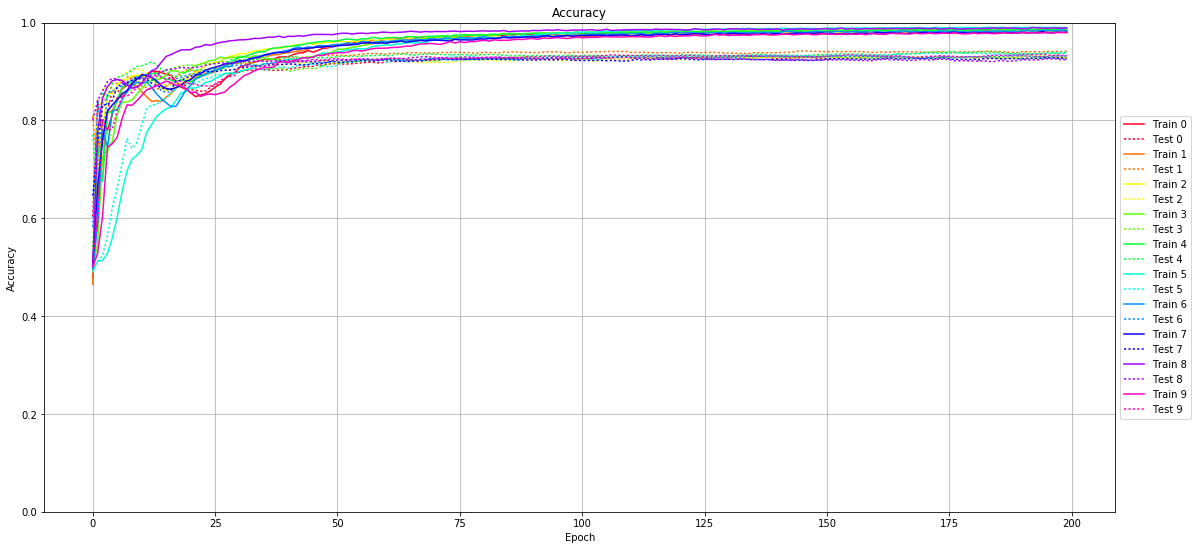

In [20]:
plot_acc(history)

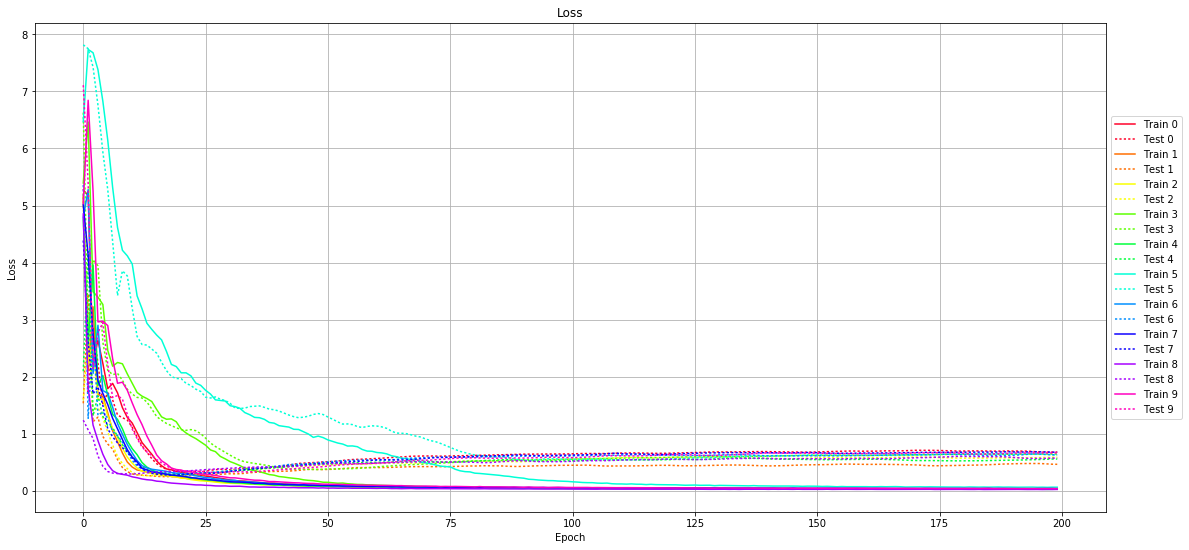

In [21]:
plot_loss(history)

In [22]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


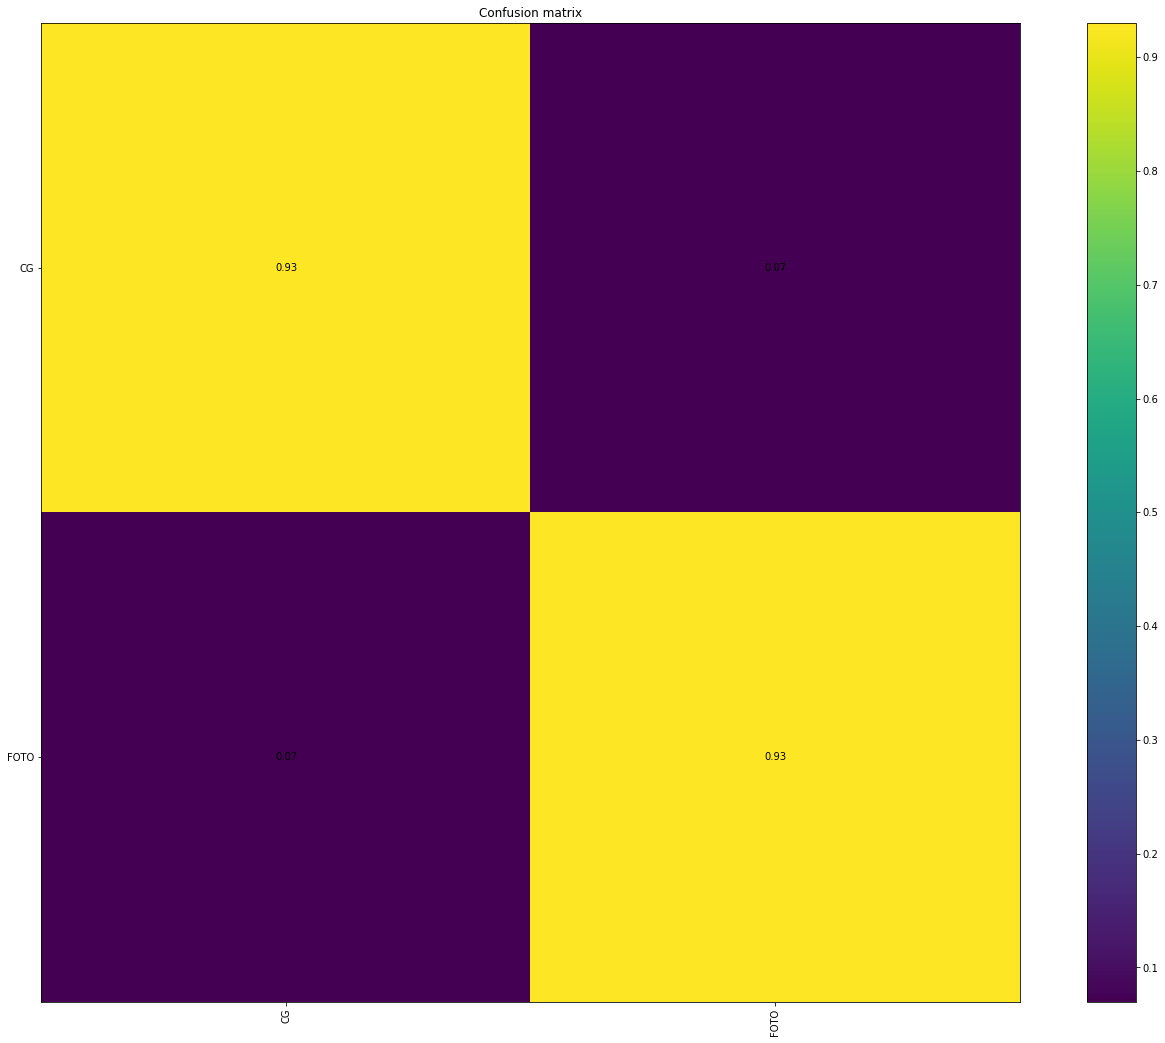

In [23]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

In [24]:
# Stacking top model (fc and softmax layers)
model.add(Flatten())                                                
model.add(Dense(160, activation='relu', name='fc1'))
model.add(Dropout(0.4))                
model.add(Dense(160, activation='relu', name='fc2'))
model.add(Dropout(0.4))              
model.add(Dense(num_classes, activation='softmax', name='predictions'))                             

In [25]:
top_weigths = "cg-top-weights-min_loss-mlp-vgg19-2layers-160neurons-relu-0.4dropout-Adam-200epochs.h5"
model.load_weights(top_weigths, by_name=True)

In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# The name of the layer we want to visualize
layer_name = 'predictions'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

Class: CG
8394
Image: ['Kitchen_9901.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['L103660.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['web_1265551721.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['web_1276206450.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['marcosR8_2.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['803.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['1206492033.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['1267803015.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['2915.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['1278316754.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['7.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['1541_4.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['957.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3466.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['AUTO_peugeotmoovie_01-0037_03.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['1024.13305.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['ab_ht5.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['348.jpg'] - Class: ['CG'

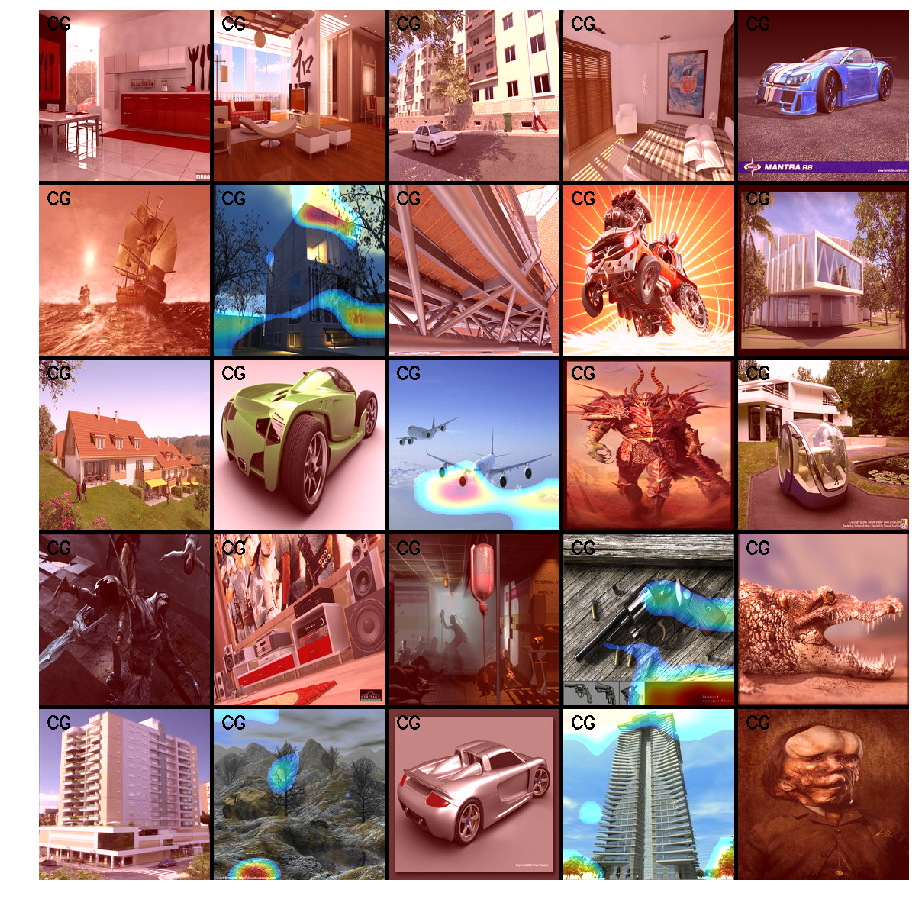

Class: FOTO
8002
Image: ['15_59_36_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['23_26_4_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['805_30_7109_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['26_33_104_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['1501_07_56_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['1212_21_1_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['23_57_25_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['26_14_40_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['07_44_98_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['901_31_9065_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['19_24_61_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['23_80_79_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['23_20_4_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['1218_22_58_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['2039_04_17_prev.jpg'] - Class: ['FOTO'] - Pred: 1 (FOTO)
Image: ['12

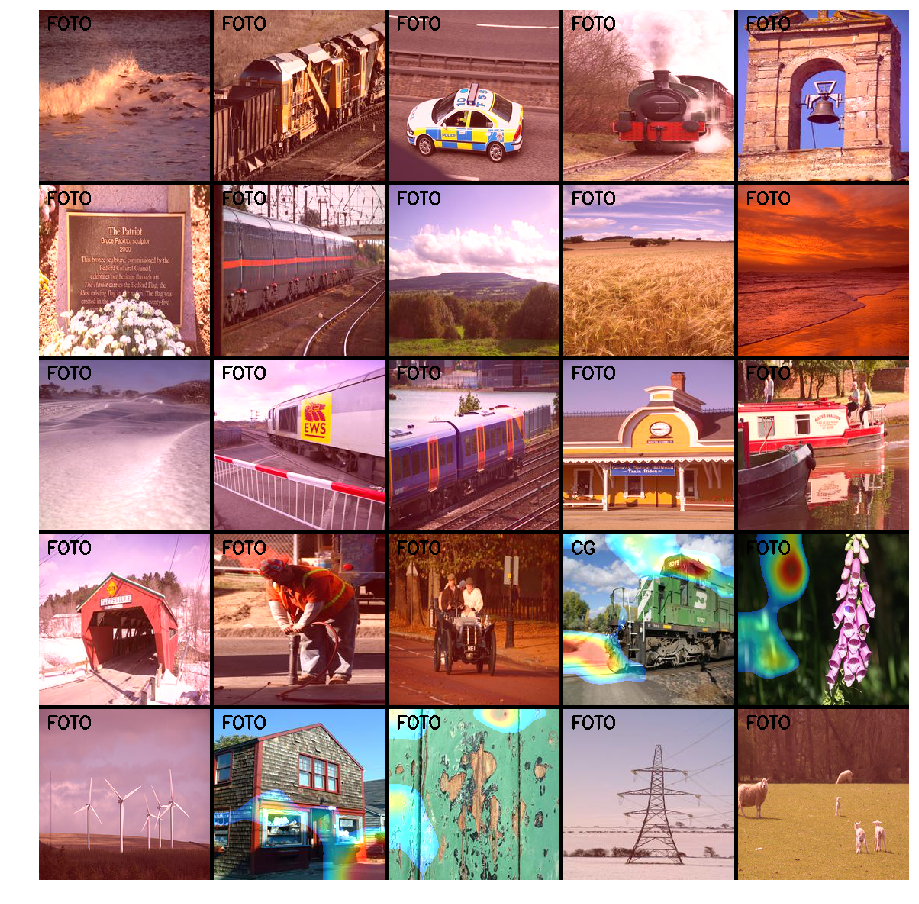

In [28]:
for fam in list_fams:
    print("Class: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name.split('/')[-2:-1]]
    print len(fam_samples)
    image_paths = random.sample(fam_samples, 25)
    
    heatmaps = []
    for path in image_paths:
        # Predict the corresponding class for use in `visualize_cam`.
        seed_img = utils.load_img(path, target_size=(224, 224))
        pred_class = np.argmax(model.predict(np.array([img_to_array(seed_img)])))
        print("Image: %s - Class: %s - Pred: %d (%s)" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class]))

        # Here we are asking it to show attention such that prob of `pred_class` is maximized.
        heatmap = visualize_cam(model, layer_idx, [pred_class], seed_img, text=list_fams[pred_class])
        heatmaps.append(heatmap)
        
    img_data = cv2.cvtColor(utils.stitch_images(heatmaps), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(img_data)
    plt.show()        